# Gemini Robotics-ER 1.5 API Test Notebook

**사전 준비:**
1. `assets` 폴더에 테스트할 이미지(e.g. `image.png`)가 있어야 합니다.
2. 유효한 Google GenAI API 키가 필요합니다.

# 셋업

### 라이브러리 설치

In [1]:
# === 0. 초기 설정: 라이브러리 설치 및 임포트 ===
# === 0. 초기 설정 (Setup) ===
# 라이브러리 설치, 임포트, API 설정, 헬퍼 함수 정의

# 1) 필요한 라이브러리 설치 (필요시 주석 해제 후 실행)
# !pip install google-genai pillow matplotlib opencv-python

# 2) 라이브러리 임포트
import os
from google import genai
from google.genai import types
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


### API 키 및 클라이언트 세팅
* api 키를 입력해 주세요요

In [3]:
# === 1. API 설정 ===
# 3) API 설정
# 여기에 API 키를 입력하거나, 환경 변수에서 가져오세요.
API_KEY = 'your api key' # <-- 여기에 본인의 API 키를 입력하세요
MODEL_ID = "gemini-robotics-er-1.5-preview"

client = genai.Client(api_key=API_KEY)



### 헬퍼 함수 정의

In [2]:
# === 2. 시각화 헬퍼 함수 정의 ===
# 4) 시각화 헬퍼 함수 정의
def plot_image_with_points(image, points_data):
    """이미지 위에 점과 라벨을 그립니다."""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    width, height = img_copy.size

    # 폰트 설정
    try:
        font = ImageFont.truetype("arial.ttf", 30)
    except IOError:
        font = ImageFont.load_default()

    for item in points_data:
        if 'point' in item:
            y_norm, x_norm = item['point']
            # 정규화된 좌표(0-1000)를 픽셀 좌표로 변환
            x = (x_norm / 1000) * width
            y = (y_norm / 1000) * height
            label = str(item.get('label', 'unknown')) # Convert label to string

            # 점 그리기
            r = 5
            draw.ellipse((x-r, y-r, x+r, y+r), fill='red', outline='white')

            # 라벨 그리기
            draw.text((x + 10, y), label, fill='yellow', font=font, stroke_width=1, stroke_fill='black')

    plt.figure(figsize=(12, 12))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

def plot_image_with_boxes(image, boxes_data):
    """이미지 위에 바운딩 박스와 라벨을 그립니다."""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    width, height = img_copy.size

    try:
        font = ImageFont.truetype("arial.ttf", 30)
    except IOError:
        font = ImageFont.load_default()

    for item in boxes_data:
        if 'box_2d' in item:
            ymin, xmin, ymax, xmax = item['box_2d']
            # 정규화된 좌표(0-1000)를 픽셀 좌표로 변환
            left = (xmin / 1000) * width
            top = (ymin / 1000) * height
            right = (xmax / 1000) * width
            bottom = (ymax / 1000) * height
            label = item.get('label', 'unknown')

            # 박스 그리기
            draw.rectangle([left, top, right, bottom], outline='green', width=3)

            # 라벨 그리기
            draw.text((left, top - 35), label, fill='green', font=font, stroke_width=1, stroke_fill='white')

    plt.figure(figsize=(12, 12))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Gemini Robotics-ER 세그멘테이션 유틸리티 함수들

이 파일은 Gemini Robotics-ER 쿡북의 세그멘테이션 관련 함수들을 포함합니다.
이미지에서 객체들의 세그멘테이션 마스크를 생성하고 시각화하는 기능을 제공합니다.
"""

# === 라이브러리 임포트 ===
import json
import base64
import dataclasses
from io import BytesIO
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont
from typing import Tuple

# === 추가 색상 목록 ===
additional_colors = [
    colorname for (colorname, colorcode) in ImageColor.colormap.items()
]

# === JSON 파싱 유틸리티 ===

def parse_json(json_output):
    """
    JSON 응답에서 마크다운 펜싱을 제거하고 파싱합니다.

    Args:
        json_output: 모델의 JSON 응답 텍스트

    Returns:
        파싱된 JSON 문자열
    """
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            # Remove everything before "```json"
            json_output = "\n".join(lines[i + 1:])
            # Remove everything after the closing "```"
            json_output = json_output.split("```")[0]
            break  # Exit the loop once "```json" is found
    return json_output

# === 이미지 처리 유틸리티 ===

def get_image_resized(img_path):
    """
    이미지를 리사이즈하여 빠른 렌더링과 작은 API 호출을 위해 준비합니다.

    Args:
        img_path: 이미지 파일 경로

    Returns:
        리사이즈된 PIL Image 객체 (800px width)
    """
    img = Image.open(img_path)
    img = img.resize(
        (800, int(800 * img.size[1] / img.size[0])), Image.Resampling.LANCZOS
    )
    return img

# === 세그멘테이션 데이터 구조 ===

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """
    세그멘테이션 마스크 데이터 클래스

    Attributes:
        y0: 바운딩 박스 상단 y 좌표 (절대 픽셀 좌표)
        x0: 바운딩 박스 좌측 x 좌표 (절대 픽셀 좌표)
        y1: 바운딩 박스 하단 y 좌표 (절대 픽셀 좌표)
        x1: 바운딩 박스 우측 x 좌표 (절대 픽셀 좌표)
        mask: 마스크 배열 [img_height, img_width] with values 0..255
        label: 객체 라벨
    """
    # bounding box pixel coordinates (not normalized)
    y0: int  # in [0..height - 1]
    x0: int  # in [0..width - 1]
    y1: int  # in [0..height - 1]
    x1: int  # in [0..width - 1]
    mask: np.array  # [img_height, img_width] with values 0..255
    label: str

# === 세그멘테이션 마스크 파싱 ===

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
    """
    모델의 JSON 응답에서 세그멘테이션 마스크들을 파싱합니다.

    Args:
        predicted_str: 모델의 JSON 응답 문자열
        img_height: 원본 이미지 높이
        img_width: 원본 이미지 너비

    Returns:
        SegmentationMask 객체들의 리스트
    """
    items = json.loads(parse_json(predicted_str))
    masks = []
    for item in items:
        raw_box = item["box_2d"]
        abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
        abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
        abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
        abs_x1 = int(item["box_2d"][3] / 1000 * img_width)
        if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
            print("Invalid bounding box", item["box_2d"])
            continue
        label = item["label"]
        png_str = item["mask"]
        if not png_str.startswith("data:image/png;base64,"):
            print("Invalid mask")
            continue
        png_str = png_str.removeprefix("data:image/png;base64,")
        png_str = base64.b64decode(png_str)
        mask = Image.open(BytesIO(png_str))
        bbox_height = abs_y1 - abs_y0
        bbox_width = abs_x1 - abs_x0
        if bbox_height < 1 or bbox_width < 1:
            print("Invalid bounding box")
            continue
        mask = mask.resize(
            (bbox_width, bbox_height), resample=Image.Resampling.BILINEAR
        )
        np_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        np_mask[abs_y0:abs_y1, abs_x0:abs_x1] = mask
        masks.append(
            SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, np_mask, label)
        )
    return masks

# === 마스크 시각화 함수들 ===

def overlay_mask_on_img(
    img: Image, mask: np.ndarray, color: str, alpha: float = 0.7
) -> Image.Image:
    """
    단일 마스크를 PIL Image에 오버레이합니다.

    Args:
        img: 베이스 PIL Image 객체
        mask: 마스크를 나타내는 PIL Image 객체. img와 동일한 높이/너비여야 함
        color: 표준 색상 이름 문자열 (예: 'red', 'blue', 'yellow')
        alpha: 오버레이 투명도 수준 (0.0 완전 투명, 1.0 완전 불투명). 기본값 0.7

    Returns:
        마스크가 오버레이된 새로운 PIL Image 객체 (RGBA 모드)

    Raises:
        ValueError: 색상 이름이 유효하지 않거나, 마스크 크기가 일치하지 않거나,
                   alpha가 0.0-1.0 범위를 벗어나거나, 입력 마스크가 2D가 아닐 경우
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("Alpha must be between 0.0 and 1.0")
    if mask.ndim != 2:
        raise ValueError(f"Mask must be 2D, but got {mask.ndim} dimensions.")

    # Convert the color name string to an RGB tuple
    try:
        color_rgb: Tuple[int, int, int] = ImageColor.getrgb(color)
    except ValueError as e:
        raise ValueError(
            f"Invalid color name '{color}'. Supported names are typically HTML/CSS "
            f"color names. Error: {e}"
        )

    # Prepare the base image for alpha compositing
    img_rgba = img.convert("RGBA")
    width, height = img_rgba.size

    # Create the colored overlay layer
    alpha_int = int(alpha * 255)
    overlay_color_rgba = color_rgb + (alpha_int,)

    # Create an RGBA layer (all zeros = transparent black)
    colored_mask_layer_np = np.zeros((height, width, 4), dtype=np.uint8)

    # Mask has values between 0 and 255, threshold at 127 to get binary mask.
    mask_np_logical = mask > 127

    # Apply the overlay color RGBA tuple where the mask is True
    colored_mask_layer_np[mask_np_logical] = overlay_color_rgba

    # Convert the NumPy layer back to a PIL Image
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, "RGBA")

    # Composite the colored mask layer onto the base image
    result_img = Image.alpha_composite(img_rgba, colored_mask_layer_pil)

    return result_img

# === 추가 헬퍼 함수들 ===

def create_segmentation_prompt(objects_list, custom_prompt=None):
    """
    세그멘테이션용 프롬프트를 생성합니다.

    Args:
        objects_list: 세그멘테이션할 객체들의 리스트 (예: ["mango", "finger"])
        custom_prompt: 커스텀 프롬프트 템플릿 (선택사항)

    Returns:
        세그멘테이션 프롬프트 문자열
    """
    import textwrap

    if custom_prompt is not None:
        # 커스텀 프롬프트가 제공되면 그대로 사용하되, 객체 리스트는 교체
        objects_str = ", ".join(objects_list)
        return custom_prompt.replace("{objects}", objects_str)

    # 기본 프롬프트 예시:
    objects_str = ", ".join(objects_list)

    prompt = textwrap.dedent(f"""
        Provide the segmentation masks for the following objects in this image:
        {objects_str}.

        The answer should follow the JSON format:
        [
          {{
            "box_2d": [ymin, xmin, ymax, xmax],
            "label": "<label for the object>",
            "mask": "data:image/png;base64,<base64 encoded PNG mask>"
          }},
          ...
        ]

        The box_2d coordinates should be normalized to 0-1000 and must be integers.
        The mask should be a base64 encoded PNG image where non-zero pixels indicate
        the mask.
    """)

    return prompt.strip()

def plot_segmentation_masks_matplotlib(img, segmentation_masks):
    """
    세그멘테이션 마스크를 matplotlib으로 시각화합니다.
    (노트북의 스타일과 호환되는 matplotlib 기반 시각화)

    Args:
        img: PIL Image 객체
        segmentation_masks: SegmentationMask 객체들의 리스트
    """
    import matplotlib.pyplot as plt

    # 초기 이미지를 표시할 이미지로 설정
    display_img = img.copy()

    # 색상 리스트 (노트북과 동일한 스타일)
    colors = [
        "red", "green", "blue", "yellow", "orange", "pink", "purple",
        "brown", "gray", "cyan", "magenta", "lime", "navy"
    ]

    # 각 마스크에 대해
    for i, mask in enumerate(segmentation_masks):
        color = colors[i % len(colors)]

        # 마스크 데이터가 비어있는지 확인
        if np.all(mask.mask == 0):
            print(f"DEBUG: Mask for object '{mask.label}' is empty (all zeros). Skipping overlay for this mask.")
            continue

        # overlay_mask_on_img 헬퍼 함수를 사용하여 마스크 오버레이 (alpha를 0.8로 변경하여 가시성 증가)
        display_img = overlay_mask_on_img(display_img, mask.mask, color, alpha=0.8)

    # 플롯 생성
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(display_img) # 마스크가 적용된 이미지를 표시
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return fig, ax

# 파일 로더

### 이미지 로드
* 원하는 이미지 파일의 경로 및 파일명을 설정해주세요

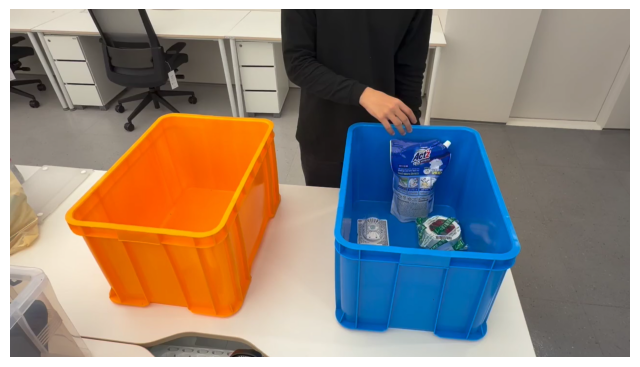

In [5]:
image_path = '/content/drive/MyDrive/Colab Notebooks/gemini_er_test/assets/image.png'

if not os.path.exists(image_path):
    print(f"Error: {image_path} 파일을 찾을 수 없습니다. assets 폴더를 확인해주세요.")
else:
    image = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 이미지 테스트

## 2. 객체 인식 (Point Detection)
이미지 내의 특정 물체들을 찾아 점(Point)으로 표시합니다.

Response: ```json
[
  {"point": [550, 260], "label": "orange storage bin"},
  {"point": [550, 650], "label": "blue storage bin"},
  {"point": [450, 650], "label": "detergent pouch"},
  {"point": [650, 600], "label": "small item in blue bin"},
  {"point": [650, 700], "label": "tape roll"},
  {"point": [300, 620], "label": "person's hand"},
  {"point": [150, 200], "label": "office chair"}
]
```


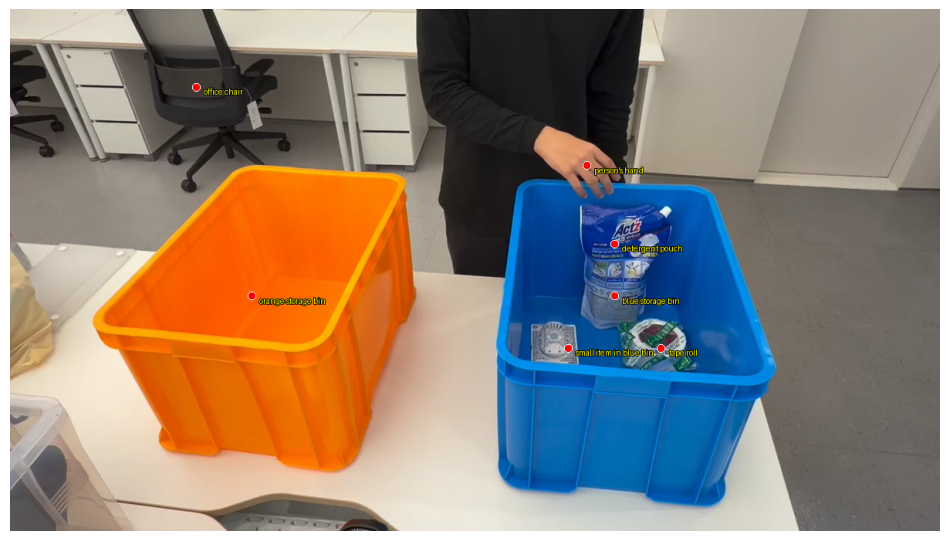

In [6]:
# 이미지 바이트 읽기
with open(image_path, 'rb') as f:
    image_bytes = f.read()

# 프롬프트 설정 (원하는 물체 목록으로 수정 가능)
# 예시:
PROMPT_POINT = """
Point to all identifiable items in the image.
The label returned should be an identifying name for the object detected.
The answer should follow the json format: [{"point": <point>, "label": <label1>}, ...].
The points are in [y, x] format normalized to 0-1000.
"""

try:
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type='image/png',
            ),
            PROMPT_POINT
        ],
        config=types.GenerateContentConfig(
            temperature=0.5,
            thinking_config=types.ThinkingConfig(thinking_budget=15000) # thinking budget range 0~24576
        )
    )

    print("Response:", response.text)

    # JSON 파싱 및 시각화
    # json code block 제거 후 파싱
    clean_text = response.text.replace('```json', '').replace('```', '').strip()
    points_data = json.loads(clean_text)

    plot_image_with_points(image, points_data)

except Exception as e:
    print(f"Error: {e}")

## 3. 객체 인식 (Bounding Box)
물체를 감싸는 박스(Bounding Box)를 검출합니다.

Response: ```json
[
  {"box_2d": [300, 88, 885, 439], "label": "orange container"},
  {"box_2d": [328, 520, 953, 821], "label": "blue container"},
  {"box_2d": [0, 435, 514, 682], "label": "person"},
  {"box_2d": [368, 608, 614, 715], "label": "laundry detergent pouch"},
  {"box_2d": [591, 653, 700, 737], "label": "round object"},
  {"box_2d": [595, 555, 688, 614], "label": "small object"}
]
```


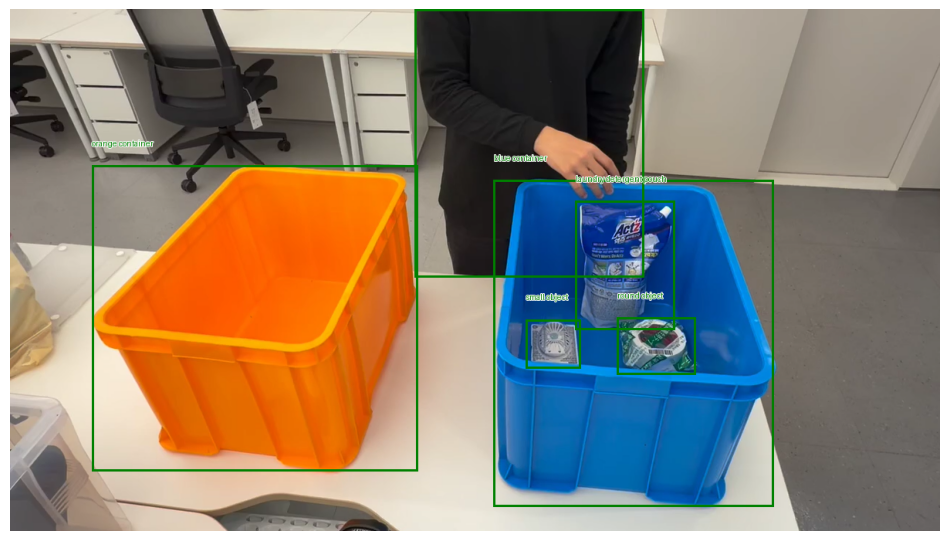

In [7]:
# 프롬프트 예시:
PROMPT_BBOX = """
Return bounding boxes for all items in the image.
Return bounding boxes as a JSON array with labels. Never return masks or code fencing.
The format should be as follows: [{"box_2d": [ymin, xmin, ymax, xmax], "label": <label>}]
normalized to 0-1000.
"""

try:
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type='image/png',
            ),
            PROMPT_BBOX
        ],
        config=types.GenerateContentConfig(
            temperature=0.5,
            thinking_config=types.ThinkingConfig(thinking_budget=0)
        )
    )

    print("Response:", response.text)

    clean_text = response.text.replace('```json', '').replace('```', '').strip()
    boxes_data = json.loads(clean_text)

    plot_image_with_boxes(image, boxes_data)

except Exception as e:
    print(f"Error: {e}")

## 4. 경로 생성 (Trajectory)
특정 물체에서 다른 위치로 이동하는 경로를 생성해 봅니다.
프롬프트의 시작점과 목표점은 이미지 내용을 보고 구체적으로 수정하는 것이 좋습니다.

Response: ```json
[
  {"point": [480, 650], "label": "start"},
  {"point": [450, 650], "label": "1"},
  {"point": [400, 650], "label": "2"},
  {"point": [350, 650], "label": "3"},
  {"point": [350, 600], "label": "4"},
  {"point": [350, 550], "label": "5"},
  {"point": [350, 500], "label": "6"},
  {"point": [350, 450], "label": "7"},
  {"point": [400, 400], "label": "8"},
  {"point": [450, 350], "label": "9"},
  {"point": [500, 300], "label": "10"},
  {"point": [550, 300], "label": "end"}
]
```


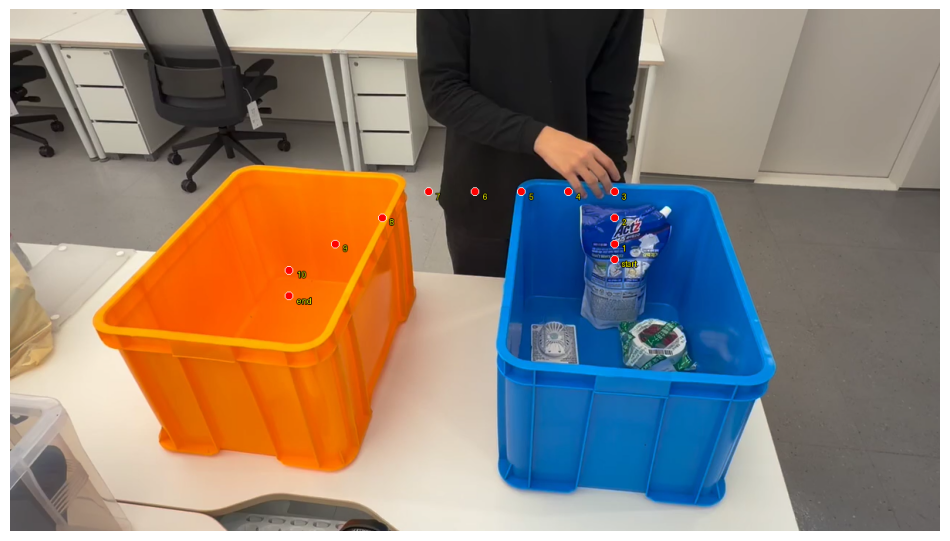

In [8]:
# 예시: 이미지에 있는 'cup'이 있다면 그 컵을 잡는 경로를 생성하는 등의 시나리오
# 지금은 일반적인 'trajectory' 요청 예시입니다.
PROMPT_TRAJ = """
Identify a box containing liquid detergent refills and an empty box. Select one liquid detergent refill pouch from the filled box. Plan a trajectory to move it into the empty box.

Place a starting point on the refill pouch, then 10 intermediate points along the path, then the final point inside the empty box.

The answer should follow the json format: [{"point": <point>, "label": <seq_num>}, ...].
"""

try:
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type='image/png',
            ),
            PROMPT_TRAJ
        ],
        config=types.GenerateContentConfig(
            temperature=0.5
        )
    )

    print("Response:", response.text)

    clean_text = response.text.replace('```json', '').replace('```', '').strip()
    traj_data = json.loads(clean_text)

    plot_image_with_points(image, traj_data)

except Exception as e:
    print(f"Error: {e}")

## 5. Segmantation

=== 세그멘테이션 테스트 실행 ===
📁 이미지: /content/drive/MyDrive/Colab Notebooks/gemini_er_test/assets/askul.png
🎯 객체들: box tape, air freshener, liquid detergent refill pouch

✅ 성공적으로 3개의 세그멘테이션 마스크를 생성했습니다.
🖼️  세그멘테이션 마스크 시각화 중...


/tmp/ipython-input-2090704753.py:191: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, "RGBA")


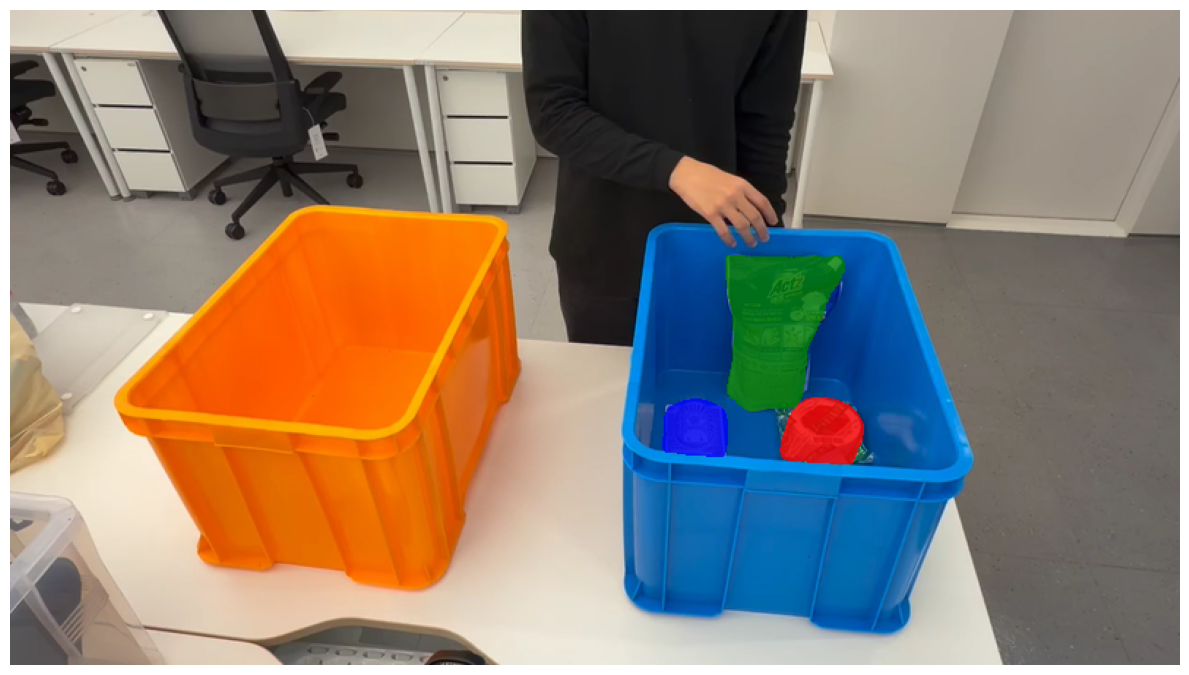

In [9]:
# 세그맨팅할 물체의 목록:
objects_to_segment = ["box tape", "air freshener", "liquid detergent refill pouch"]

# ===========================================
# 🚀 Colab 실행 코드
# ===========================================

print("=== 세그멘테이션 테스트 실행 ===")
print(f"📁 이미지: {image_path}")
print(f"🎯 객체들: {', '.join(objects_to_segment)}")
print()

# 이미지 바이트 읽기
with open(image_path, 'rb') as f:
    image_bytes = f.read()

# 프롬프트 생성 (커스텀 프롬프트 대신 헬퍼 함수가 생성하는 기본 프롬프트 사용)
prompt = create_segmentation_prompt(objects_list=objects_to_segment)

try:
    # Gemini API 호출 (client는 이미 정의되어 있다고 가정)
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type='image/png',
            ),
            prompt
        ],
        config=types.GenerateContentConfig(
            temperature=0.5,
            thinking_config=types.ThinkingConfig(thinking_budget=15000)
        )
    )

    # JSON 파싱 (helper function, returns string)
    json_output_str = parse_json(response.text)

    segmentation_masks = []
    try:
        # 이미지 로드 (시각화를 위해)
        img = get_image_resized(image_path)
        img_width, img_height = img.size

        # 마스크 파싱 (JSONDecodeError 발생 가능)
        segmentation_masks = parse_segmentation_masks(
            json_output_str, img_height=img_height, img_width=img_width
        )
    except json.decoder.JSONDecodeError as json_err:
        print(f"❌ JSON 파싱 오류: {json_err}")
        print("모델이 예상된 JSON 형식을 반환하지 않았습니다. 원본 응답을 확인하세요.")
        print(f"원본 응답 내용: {json_output_str}")
        print("세그멘테이션 마스크를 생성할 수 없습니다.")


    if segmentation_masks:
        print(f"✅ 성공적으로 {len(segmentation_masks)}개의 세그멘테이션 마스크를 생성했습니다.")

        # matplotlib으로 세그멘테이션 마스크 시각화
        print("🖼️  세그멘테이션 마스크 시각화 중...")
        plot_segmentation_masks_matplotlib(img, segmentation_masks)
    else:
        print("⚠️  세그멘테이션 마스크를 찾을 수 없습니다.")

except Exception as e:
    print(f"❌ 세그멘테이션 테스트 실패: {e}")
    import traceback
    traceback.print_exc()